In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

# Statistical Inferences into the Housing Development Industry

## Overview

This notebook is meant to be a supplement to the main notebook of this repository to show the contrast between the data presented as our main analysis and what the data and analyses would look like without any sort of filtering or transformations. I decided to include this because during the process of developing these models, I came across higher statistics when using unfiltered data, but noticed that they were more unreliable models than what came out in the final product. The code and the comments in this notebook will be condensed so we can more easily see the main takeaways from this alternative analysis.

## Importing the data

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
housing_df = df.drop(['view', 'lat', 'long', 'grade', 'bathrooms',
                      'sqft_living15', 'sqft_lot15', 'zipcode', 
                      'sqft_above', 'sqft_basement', 'date', 
                      'yr_renovated', 'waterfront'], axis = 1)

In [4]:
housing_df['id'] = housing_df['id'].astype('str')

We will be going into this analysis with this data as-is. For reference, we have a pairplot of `housing_df` without any sort of filtering, transformation, or feature scaling performed.

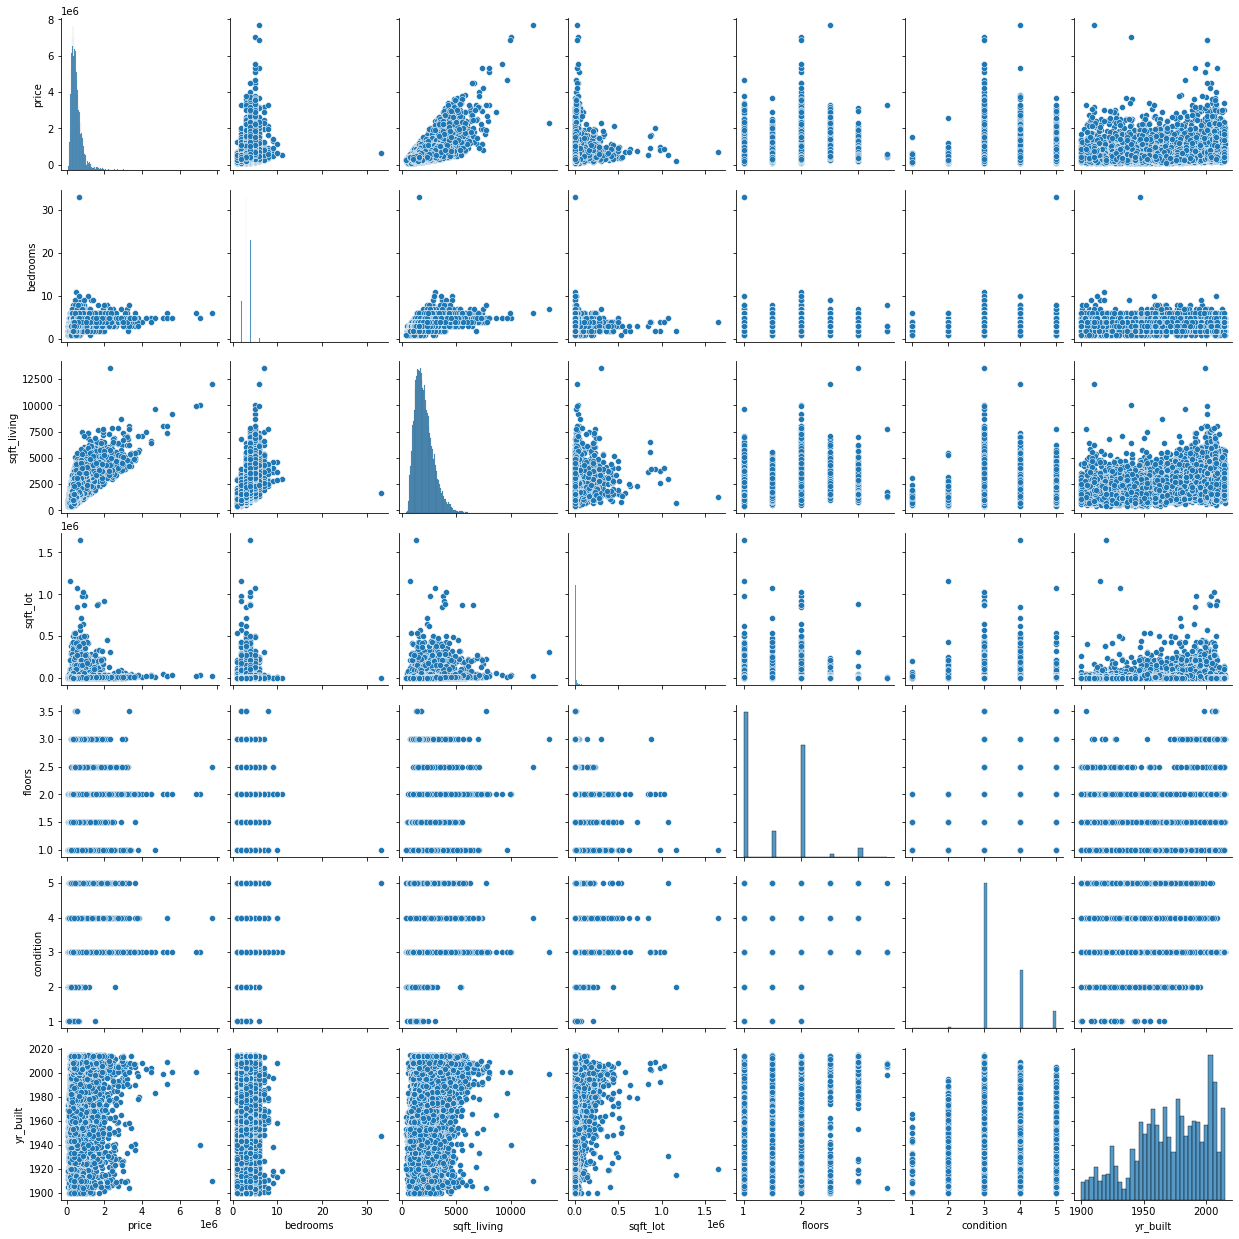

In [5]:
sns.pairplot(housing_df)

## Creating first model

In [6]:
def ols_analysis(df, formula):
    """
    Takes in a dataframe and a regression formula and creates a regression model
    of the data using OLS regression.
    """
    results = ols(formula=formula, data=df).fit()
    return results

def print_params(model):
    """
    Takes in a regression model and prints the R-squared and parameters for
    easier inspection and analysis.
    """
    rsquared = model.rsquared
    params = model.params

    print(f'R-squared: {rsquared}')
    print('----------')
    print('Beta values:')
    print(params)

As done in the original analysis, we start by making a simple model with `sqft_living` as our only predictor.

In [7]:
fsm_df = housing_df[['price', 'sqft_living']]
formula = 'price ~ sqft_living'
fsm_results = ols_analysis(fsm_df, formula)
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        00:19:57   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
print_params(fsm_results)

R-squared: 0.49268789904035093
----------
Beta values:
Intercept     -43988.892194
sqft_living      280.863014
dtype: float64


Already we can see that our regression statistic is higher than any of those returned in our original analysis. One thing to point out, however, is that we get a notice at the bottom of our summary notifying us of a large condition number that might indicate multicollinearity. We will address that later, but for now we can just check our assumptions of linear regression.

### Checking assumptions of linear regression

In [9]:
def linearity_test(model):
    """
    Takes a linear regression model and calculates the rainbow statistic and p-value
    to check if the model meets the assumption of linearity.
    """
    rainbow_statistic, rainbow_p_value = linear_rainbow(model)
    print("Rainbow statistic:", rainbow_statistic)
    print("Rainbow p-value:", rainbow_p_value)
    
def normality_test(resids):
    """
    Takes the residuals of a linear regression model and creates a Q-Q
    plot to exhibit whether the model meets the assumption of normality.
    """
    fig = sm.graphics.qqplot(resids, dist=stats.norm, line='45', fit=True)
    fig.show()
    
def homoscedasticity(df, model, resids):
    """
    Takes in a linear regression model and its residuals and creates a scatter plot
    to help determine whether the model meets the assumption of homoscadasticity.
    """
    y = df.iloc[:, 0]
    y_hat = model.predict()
    fig, ax = plt.subplots()
    ax.set(xlabel="Predicted {}".format(y.name),
           ylabel="Residuals (Actual - Predicted {})".format(y.name))
    return ax.scatter(y_hat, resids);

def breusch_pagan(df, resids):
    """
    Takes in a dataframe for a linear regression model and its residuals to measure
    for heteroscedasticity.
    """
    predictors_df = df.drop(df.columns[0], axis=1)
    lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(resids, predictors_df)
    print("Lagrange Multiplier p-value:", lm_p_value)
    print("F-statistic p-value:", f_p_value)
    
def independence_test(df):
    """
    Takes in a dataframe for a linear regression model and returns a new dataframe
    containing the variance inflation factors for each feature in the model.
    """
    predictors_df = df.drop(df.columns[0], axis=1)
    rows = predictors_df.values
    vif_df = pd.DataFrame()
    vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(predictors_df.columns))]
    vif_df["feature"] = predictors_df.columns
    return vif_df   

### 1. Linearity

In [10]:
linearity_test(fsm_results)

Rainbow statistic: 1.0880045442869077
Rainbow p-value: 5.894761434174282e-06


The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not. Since the p-value is very low, at an alpha level of 0.05, we would reject the null; therefore this model violates the assumption of linearity.

### 2. Normality

<ipython-input-9-b65441163ba0>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


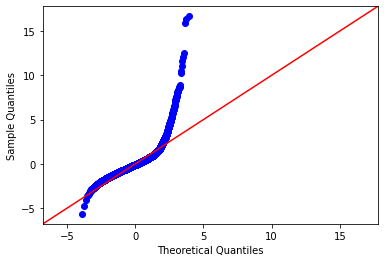

In [11]:
fsm_resids = fsm_results.resid
normality_test(fsm_resids)

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. The JB p-value is low, thus we would reject the null, meaning that the residuals are not normally distributed. The Q-Q plot also reflects this, showing that the model is skewed.

### 3. Homoscadasticity

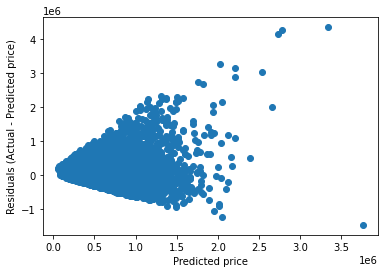

In [12]:
homoscedasticity(fsm_df, fsm_results, fsm_resids)

The scatter plot has a conal shape, indicating that the scatter of the dependent variable widens as the value of the independent variable increases.

In [13]:
breusch_pagan(fsm_df, fsm_resids)

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


A low F-statistic means we would reject the null; therefore this model is heteroscedastic and violates the assumption of homoscedasticity.

### 4. Independence

As seen earlier, the high condition number indicates that there might be strong signs of multicollinearity in our model. However, since our model only has one indpendent variable for now, it is reasonable to assume that our model currently meets the independence assumption, and we don't have to check for this assumption.

## Adding another numerical feature to the model


Next, we will add `sqft_lot` to our model and see how it changes.

In [14]:
model_2_df = housing_df[['price', 'sqft_living', 'sqft_lot']]
formula_2 = "price ~ sqft_living + sqft_lot"
model_2_results = ols_analysis(model_2_df, formula_2)
model_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 1.053e+04
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        00:19:57   Log-Likelihood:            -3.0004e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.001e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.433e+04   4405.869    -10.062      0.000    -5.3e+04   -3.57e+04
sqft_living   283.1438      1.967    143.927      0.000     279.288     287.000
sqft_lot       -0.2915      0.044     -6.684      0.000      -0.377      -0.206
==============================================================================
Omnibus:                    14737.142   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           534322.524
Skew:                           2.805   Prob(JB):                         0.00
Kurtosis:                      26.713   Cond. No.                     1.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared hasn't improved much at all, only going up to 0.494. Let's go ahead and check the assumptions of linear regression.

### 1. Linearity

In [15]:
linearity_test(model_2_results)

Rainbow statistic: 1.0908272433312955
Rainbow p-value: 3.152586659132877e-06


Again, we see a low p-value, so we can conclude this model violates the linearity assumption.

### 2. Normality

<ipython-input-9-b65441163ba0>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


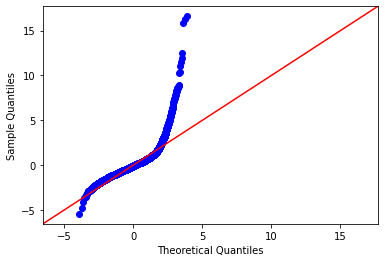

In [16]:
model_2_resids = model_2_results.resid
normality_test(model_2_resids)

The Q-Q plot still shows that the distribution is skewed, and the JB p-value is still low, therefore indicating that this model violates the normality assumption.

### 3. Homoscadasticity

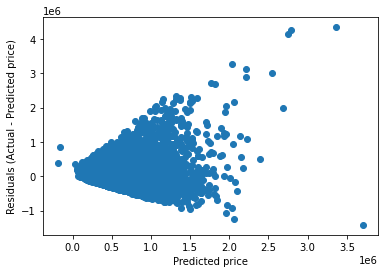

In [17]:
homoscedasticity(model_2_df, model_2_results, model_2_resids)

In [18]:
breusch_pagan(model_2_df, model_2_resids)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


Our scatter plot still exhibits a conal shape, and our test returned a low p-value, so the model violates homoscedasticity.

### 4. Independence

In [19]:
independence_test(model_2_df)

,VIF,feature
0,1.16793,sqft_living
1,1.16793,sqft_lot


Although we also got the warning for a high condition number on this regression, we're still okay with the independence assumption. As a reminder, a VIF of greater than 5 is considered too high and indicates multicollinearity; since the VIFs for these variables are low, we can safely say that we don't violate this assumption.

## Adding a categorical feature to the model

Lastly, we'll add the categorical feature `condition` to our model. Since this is the model we ended up picking as the best in our original analysis, I won't be adding `floors` here.

In [20]:
model_3_df = housing_df[['price', 'sqft_living', 'sqft_lot', 'condition']]
formula_3 = 'price ~ sqft_living + sqft_lot + condition'
model_3_results = ols_analysis(model_3_df, formula_3)
model_3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     7192.
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        00:19:58   Log-Likelihood:            -2.9991e+05
No. Observations:               21597   AIC:                         5.998e+05
Df Residuals:                   21593   BIC:                         5.999e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.986e+05   1.05e+04    -18.947      0.000   -2.19e+05   -1.78e+05
sqft_living   285.0099      1.959    145.498      0.000     281.170     288.849
sqft_lot       -0.2926      0.043     -6.749      0.000      -0.378      -0.208
condition    4.411e+04   2722.714     16.200      0.000    3.88e+04    4.94e+04
==============================================================================
Omnibus:                    14769.452   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           544934.345
Skew:                           2.808   Prob(JB):                         0.00
Kurtosis:                      26.959   Cond. No.                     2.69e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our R-squared has increased to 0.500, which is pretty significant. But is this model any better with meeting the linear regresson assumptions?

### 1. Linearity

In [21]:
linearity_test(model_3_results)

Rainbow statistic: 1.0931015700786906
Rainbow p-value: 1.8826619902110187e-06


Our p-value is still low, and we still have a model that violates linearity.

### 2. Normality

<ipython-input-9-b65441163ba0>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


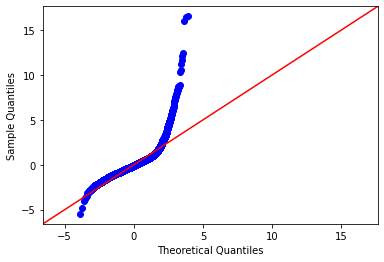

In [22]:
model_3_resids = model_3_results.resid
normality_test(model_3_resids)

Our Q-Q plot looks about the same, and our JB p-value is still low, so this model violates normality.

### 3. Homoscadsticity

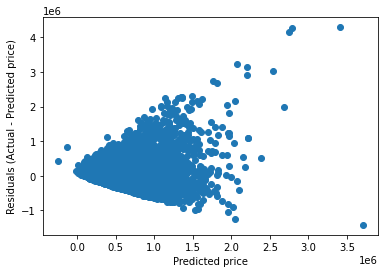

In [23]:
homoscedasticity(model_3_df, model_3_results, model_3_resids)

In [24]:
breusch_pagan(model_3_df, model_3_resids)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


Our scatter plot also looks similar to that of our previous models, and our test's p-value is still low, so this model also violates homoscedasticity.

### 4. Independence

In [25]:
independence_test(model_3_df)

,VIF,feature
0,5.172879,sqft_living
1,1.168046,sqft_lot
2,4.988738,condition


With this model, not only did we see the large condition number message, but we also see a higher VIF for `sqft_living` and a slightly lower, but still high VIF for `condition`. Unfortunately, this model has violated the independence assumption as well.

## Conclusion

The regression statistics across all our models were higher than in our main notebook. However, all of them would violate all the assumptions of linear regression, meaning that although they can be used to explain a bigger population of housing prices, these results are less trustworthy than those in our main analysis. With this supplementary notebook, I would like to show that just because a model returns higher regression statistics, doesn't always mean the model is reliable. This is a case where transformations, filtering, and feature scaling is a very important step to obtain the best statistical results possible.